# 실시간 기사 키워드 크롤링 프로젝트

## 1. 배경
- ‘제4의 권력’이라 불려온 언론은 과거 정보와 이슈 메이킹을 독점하는 주체였음. 하지만 ICT 기술의 발전과 디지털 매체의 난립, 유튜브 등 강력한 대체제의 등장으로 정보 전달과 이슈 변화의 속도가 그 어느 때보다 빨라지며 중견매체들도 생존을 위협받고 있는 상황.
- 각 언론사들은 각자도생을 위해 영상팀, 디지털 이슈 전담팀 등을 구성하는가 하면 조직 체계 개편에 나서기도. 특히 구독 경제가 이뤄지지 않고 있는 한국 언론 생태계로 인해 PV를 높이기 위해 돈이 되는 어뷰징, 속보성 기사에 골몰. 예전처럼 중량감 있는 기획 기사와 탐사보도 기사 등이 나오기 어려워지고 있는 구조. 언론사들도 기자들에게도 정확성보다 신속성을 더 강하게 요구하고 있음. 기사의 기본을 지키지 않거나 팩트체크조차 제대로 되지 않은 받아쓰기 기사가 난립하는 이유. 
- 기자들에게 과중된 속보성 단신 처리 작업을 최대한 줄여, 기자들에게 여유를 주고 본연의 역할인 권력 견제에 충실하도록 만들고자 이번 프로젝트 고안. AI를 통해 원하는 정보를 실시간으로 수집, 분석할 수 있는 툴을 제공하고자 함.

## 2. 문제 정의
- '실시간 기사 키워드 크롤링-DB 저장-메신저 전송' 파이프라인 모델링
    - 검색 키워드 입력 시 xpath, selenium, scrapy 활용해 5분 단위로 관련 기사 크롤링 후 데이터베이스에 저장하고, 분석 및 메신저 전송까지 해주는 모델 구축.

## 3. 프로젝트 계획 및 절차

In [32]:
# 키워드로 데이터 크롤링 - 감성 분석 - 데이터베이스 저장 및 메신저 전송
# 사용 기술 xpath, selenium, scrapy, mongodb, 감성 분석, (crontab, word cloud, api)

In [13]:
# get 방식: query(내용) 있음
# html 정적 페이지 방식

In [2]:
# 절차
# 1. 웹페이지 분석 및 selector(xpath) 찾기
# 2. scrapy 프로젝트 생성 및 코드 작성(items > spider > pipeline)
# 3. scrapy 실행(크롤링)

## 4. 크롤링(실시간 기사 키워드 검색)

### 4-1. 웹페이지 분석 및 selector(xpath) 찾기

In [1]:
from scrapy.http import TextResponse
from selenium import webdriver
from fake_useragent import UserAgent
import scrapy
import requests
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action = "ignore") # 경고 무시

In [2]:
# 1. 웹페이지 분석 : URL
query = "이인영"
url = "https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query={}".format(query)

print(url)

https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=이인영


In [42]:
# url에 데이터(query)가 포함되는 get 방식

# get: url에 데이터가 포함 -> 데이터 노출, 길이 제한이 있음
# post: body에 데이터 포함 -> 데이터 숨겨짐

In [ ]:
# 웹페이지를 살펴보면 html 형태(정적 페이지 방식)인 것을 확인할 수 있다.

# web crawling
- 1. requests: json: 동적 페이지(url 변경 없이 데이터를 수정 및 추가)
- 2. requests: html : 정적 페이지(url 변경으로 데이터를 수정 및 추가)
- 3. selenium: web browser : 1, 2번 방법을 사용하지 못할 때 사용
    - 서버쪽으로 데이터 요청해서 받아오는 게 아니라 우리가 직접 크롬 드라이버를 띄워서 그 브라우저에서 데이터 가져오는 방법

In [3]:
# 2. requests -> response : HTML(str)
req = requests.get(url)
response = TextResponse(req.url, body=req.text, encoding='utf-8')
response

# 참고 : request, response: JSON(str)
# def get_stock_data(code, page_size=20, page=1):
#     url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?\
# code={}&pageSize={}&page={}".format(code, page_size, page)
#     response = requests.get(url)
#     datas = response.json()["result"]["siseList"]
#     return pd.DataFrame(datas)

<200 https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81>

'<!DOCTYPE html> <html lang="ko" class=""> <head> <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"> <meta http-equiv="Content-Script-Type" content="text/javascript"> <meta name="referrer" content="always"> <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0, minimum-scale=1.0, user-scalable=yes"> <meta name="format-detection" content="telephone=no,address=no,email=no"> <meta property="og:title" content="이인영 : 네이버 뉴스검색"/> <meta property="og:image" content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png"> <meta property="og:description" content="\'이인영\'의 네이버 뉴스검색 결과입니다."> <meta name="description" lang="ko" content="\'이인영\'의 네이버 뉴스검색 결과입니다."> <title>이인영 : 네이버 뉴스검색</title> <link rel="shortcut icon" href="https://ssl.pstatic.net/sstatic/search/favicon/favicon_191118.ico"> <style type="text/css"> noscript_disp { display: none; } </style>  <noscript> <style type="text/css"> noscript_disp { display: block; } </style> </noscript><sc
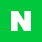
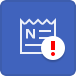

In [4]:
response.text

In [8]:
query = "이인영"
url = "https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query={}".format(query)

driver = webdriver.Chrome()
driver.get(url)

In [9]:
# 3. xpath 활용해 페이지별 기사 링크 추출
elements = driver.find_elements_by_xpath('//*[@id="news_result_list"]/li/div/a')
links = [element.get_attribute("href") for element in elements]
links

# links = response.xpath('//*[@id="news_result_list"]/li/div/a/@href').extract() # html 방식에서
# //*[@id="news_result_list"]/li[1]/div[1]/a
# //*[@id="news_result_list"]/li[2]/div[1]/a
# //*[@id="news_result_list"]/li[3]/div[1]/a

['https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=001&aid=0011781951',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=056&aid=0010877761',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=079&aid=0003389982',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=002&aid=0002144408',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=119&aid=0002418565',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=055&aid=0000831340',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=366&aid=0000562943',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=047&aid=0002278840',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=052&aid=0001471393',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=123&aid=0002227867',
 'https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=421&aid=0004785031',
 'https://m.news.naver.com/read.nhn?mode=LS

In [10]:
# 4. 기사별 상세 콘텐츠 추출 : scrapy requests
url = links[-1] # 마지막 기사, 나머지 구조는 모두 같으므로
headers = {"User-Agent": UserAgent().chrome} # 파이썬으로 접근 시 403에러 피하기 위한 fake user_agent
req = requests.get(url, headers=headers)
response = TextResponse(req.url, body=req.text, encoding="utf-8")
response

<200 https://n.news.naver.com/mnews/article/022/0003489625?sid=100>

In [11]:
# title
title = response.xpath('//*[@id="ct"]/div[1]/div[2]/h2/text()')[0].extract().strip()
#.extract().split(">")[1].split("<")[0]

# date
date = response.xpath('//*[@id="ct"]/div[1]/div[3]/div[1]/div/span/text()')[0].extract().strip()

# category
category = response.xpath('//*[@id="_LNB"]/ul/li[2]/a/span/text()')[0].extract().strip()

# sub_title
sub_title = response.xpath('//*[@id="dic_area"]/strong/text()').extract()
sub_title = "… ".join(sub_title).strip()
# //*[@id="dic_area"]/strong/text()[1]
# //*[@id="dic_area"]/strong/text()[2]

# body
body = response.xpath('//*[@id="dic_area"]/text()').extract()
body = "".join(body).strip()
title, date, category, sub_title, body

('한미연합훈련 보류 위해 이재명·이인영 의기투합하나',
 '2020.07.31. 오후 3:02',
 '정치',
 '',
 '여권 유력 정치인인 이재명 경기도지사와 이인영 통일부 장관이 ‘의기투합’을 할까. 경기도가 통일부에 오는 8월로 예정된 한미연합 군사훈련 취소를 건의해 결과가 주목된다.     31일 경기도에 따르면 한미연합 군사훈련 취소를 건의한 이유는 크게 두 가지다. 우선 신종 코로나바이러스 감염증(코로나19) 확산 억지를 위해서다. 경기도 평택에 있는 주한미군 사령부에선 최근 끊임없이 코로나19 확진자가 발생하고 있다.     경기도 측은 “현 상황에서 한미연합 군사훈련이 진행된다면 코로나19가 한미 양국 군인은 물론 주한미군이 집중된 경기도 지역사회로의 감염 확산 우려도 크다”고 밝혔다. 이어 “유엔 안전보장이사회도 코로나19와 관련해 무력분쟁 중단 촉구 결의안을 채택한 바 있다”며 “코로나19 극복을 위해 전 세계가 무력 분쟁을 멈추고 있는 지금 어떤 이유도 전쟁 훈련의 명분이 될 수는 없다”고 주장했다.     남북 간 신뢰 회복도 이유로 꼽았다. 문재인 대통령은 올해 들어 취임 3주년 특별 연설과 21대 국회 개원 기념 연설 등에서 잇따라 북한에 ‘러브콜’을 보냈지만 북한은 이를 차갑게 외면하고 있다. 북한 노동당 김여정 제1부부장은 개성 남북공동연락사무소 폭파를 명령했고, 김정은 국무위원장은 핵무력 완성과 그를 통한 전쟁 억지력을 공언했다.     경기도 측은 “한미연합 군사훈련은 ‘명백한 남북 정상 간의 합의 위반’이라고 주장하는 북의 군사적 대응을 촉발 할 수 있다”며 “상대를 자극하는 한미연합 군사훈련이 아니라 신뢰를 키우는 남북협력 훈련이 필요한 때”라고 강조했다. 이어 “평화의 물을 길어오려면 대화의 물동이를 던져야 한다”며 “남북협력 훈련은 남북간 대화, 교류, 협력을 모색해 나가자는 의미”라고 덧붙였다.    한미연합 군사훈련은 국방부가 결정할 사안이다. 주무부처가 아닌 통일부로서도 의견을 낼 수 있을 뿐이다. 다만 이재명 

In [ ]:
# 4. HTML(str) > parsing(bs_obj) > BeautifulSoup Obj(css-selector) : DF
# from bs4 import BeautifulSoup

# dom = BeautifulSoup(req.content, "html.parser") # 오브젝트로 파싱

# body = dom.select(".newsct_body > div > div")
# element = dom.select(".media_end_head_info_variety > div > div > div > a")

# element

# dom
    # select : 여러 개의 element 객체를 리스트로 가져옴
    # select_one : 하나의 엘리먼트 객체를 가져옴
    
# like = response.xpath('//*[@id="commentFontGroup"]/div[1]/div')[0].extract()
# like

### 4-2. scrapy 프로젝트 생성 및 코드 작성(items > spider > pipeline)

In [37]:
# !rm -rf naver_article

In [12]:
# 프로젝트 만들기
# !rm -rf naver_article
!scrapy startproject naver_article

Error: scrapy.cfg already exists in /Users/Im/Documents/code/project/Crawling_project/naver_article


In [24]:
# 1. items.py 코드 작성

In [3]:
%%writefile naver_article/naver_article/items.py

import scrapy

class NaverArticleItem(scrapy.Item):
    title = scrapy.Field()
    date = scrapy.Field()
    category = scrapy.Field()
    sub_title = scrapy.Field()
    body = scrapy.Field()
    link = scrapy.Field()

Overwriting naver_article/naver_article/items.py


In [22]:
!tree naver_article

naver_article
├── naver_article
│   ├── __init__.py
│   ├── __pycache__
│   ├── items.py
│   ├── middlewares.py
│   ├── pipelines.py
│   ├── settings.py
│   └── spiders
│       ├── __init__.py
│       └── __pycache__
└── scrapy.cfg

4 directories, 7 files


In [23]:
# 2. spider.py 코드 작성

In [13]:
%%writefile naver_article/naver_article/spiders/spider.py

import scrapy
from naver_article.items import NaverArticleItem
from selenium import webdriver
from fake_useragent import UserAgent

class Spider(scrapy.Spider):
    name = "NaverArticle"
    allow_domain = ["https://m.search.naver.com"]
    
    query = "이인영"
    start_urls = ["https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query={}".format(query)]
    
    custom_settings = {
        "DOWNLOADER_MIDDLEWARES": {
            "scrapy.downloadmiddlewares.useragent.UserAgentMiddleware": None,
            "scrapy_fake_useragent.middleware.RandomUserAgentMiddleware": 400,
        }
    } # fake user_agent
        
    def parse(self, response):
        driver = webdriver.Chrome()
        datas = []
        for page in range(3):
            query = "이인영"
            page = 1 + (page * 15)
            url = "https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query={}&start={}".format(query, page)
            driver.get(url)
            elements = driver.find_elements_by_xpath('//*[@id="news_result_list"]/li/div/a')
            links = [element.get_attribute("href") for element in elements]
            for link in links:
                yield scrapy.Request(link, callback=self.parse_content)
        driver.quit()

    def parse_content(self, response):
        item = NaverArticleItem()
        item['title'] = response.xpath('//*[@id="ct"]/div[1]/div[2]/h2/text()')[0].extract().strip()
        item['date'] = response.xpath('//*[@id="ct"]/div[1]/div[3]/div[1]/div/span/text()')[0].extract().strip()
        item['category'] = response.xpath('//*[@id="_LNB"]/ul/li[2]/a/span/text()')[0].extract().strip()
        sub_title = response.xpath('//*[@id="dic_area"]/strong/text()').extract()
        item['sub_title'] = "… ".join(sub_title).strip()
        body = response.xpath('//*[@id="dic_area"]/text()').extract()
        item['body'] = "".join(body).strip()
        item['link'] = response.url
        yield item
        
# datas.append({"title": item['title'], "date": item['date'], "category": item['category'], "sub_title": item['sub_title'], "body": item['body'], "link": item['link']})

Overwriting naver_article/naver_article/spiders/spider.py


### 4-3. settings.py 설정 변경

In [73]:
# settings.py : robots_obey = False 수정
# !sed -i .bak 's/ROBOTSTXT_OBEY = True/ROBOTSTXT_OBEY = False/' naver_movie/naver_movie/settings.py 
# 그대로 하면 에러 뜬다. 네이버 정책상 데이터 공개가 아니기 때문
    # Forbidden by robots.txt: <GET https://movie.naver.com/movie/running/current.nhn>
# 참고: awk, 텍스트 굉장히 빠름. sed를 가져다 만든 것

## 5. scrapy 실행 및 csv 저장

In [74]:
# scrapy.cfg 파일이 있는 디렉토리에서 $ scrapy crawl <spider name>으로 실행
# 실행 절차
# cd gmarket
# scrapy gmarket GmarketBestsellers

In [75]:
!tree naver_article/

naver_article/
├── naver_article
│   ├── __init__.py
│   ├── __pycache__
│   │   ├── __init__.cpython-36.pyc
│   │   ├── items.cpython-36.pyc
│   │   └── settings.cpython-36.pyc
│   ├── items.py
│   ├── middlewares.py
│   ├── pipelines.py
│   ├── settings.py
│   └── spiders
│       ├── __init__.py
│       ├── __pycache__
│       │   ├── __init__.cpython-36.pyc
│       │   └── spider.cpython-36.pyc
│       └── spider.py
└── scrapy.cfg

4 directories, 13 files


In [15]:
%%writefile run.sh
cd naver_article
scrapy crawl NaverArticle -o naver_article.csv

Overwriting run.sh


In [16]:
!chmod 777 run.sh

In [17]:
!rm naver_article/naver_article.csv
!source run.sh
#!. ../run.sh

rm: naver_article/naver_article.csv: No such file or directory
2020-07-31 18:00:00 [scrapy.utils.log] INFO: Scrapy 2.2.0 started (bot: naver_article)
2020-07-31 18:00:00 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-19.4.0-x86_64-i386-64bit
2020-07-31 18:00:00 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-07-31 18:00:00 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'naver_article',
 'NEWSPIDER_MODULE': 'naver_article.spiders',
 'SPIDER_MODULES': ['naver_article.spiders']}
2020-07-31 18:00:00 [scrapy.extensions.telnet] INFO: Telnet Password: e741cb7d3264981d
2020-07-31 18:00:00 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.tel

2020-07-31 18:00:07 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:07 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:07 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:07 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:07 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/url {"url": "https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=\uc774\uc778\uc601&start=16"}
2020-07-31 18:00:08 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/url HTTP/1.1" 200 14
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/elements {"using": "xpath", "value": "//*[@id=\"news_result_list\"]/li/div/a"}
2020-07-31 18:00:08 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/elements HTTP/1.1" 200 1196
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:08 [selenium.webdriver.remote.re

2020-07-31 18:00:08 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:08 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:08 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:08 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/elements HTTP/1.1" 200 1196
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments.l

2020-07-31 18:00:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments.length;k++)e[k-2]=arguments[k];return a.prototype[c].apply(b,e)}})();var m=\"unknown error\",l={15:\"element not selectable\",11:\"element not visible\"};l[31]=m;l[30]=m;l[24]=\"invalid cookie domain\";l[29]=\"invalid element coordinates\";l[

2020-07-31 18:00:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:09 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061/execute/sync {"script": "return (function(){return function(){var d=this;function f(a){return\"string\"==typeof a};function h(a,b){this.code=a;this.a=l[a]||m;this.message=b||\"\";a=this.a.replace(/((?:^|\\s+)[a-z])/g,function(a){return a.toUpperCase().replace(/^[\\s\\xa0]+/g,\"\")});b=a.length-5;if(0>b||a.indexOf(\"Error\",b)!=b)a+=\"Error\";this.name=a;a=Error(this.message);a.name=this.name;this.stack=a.stack||\"\"}\n(function(){var a=Error;function b(){}b.prototype=a.prototype;h.b=a.prototype;h.prototype=new b;h.prototype.constructor=h;h.a=function(b,c,g){for(var e=Array(arguments.length-2),k=2;k<arguments

2020-07-31 18:00:10 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "POST /session/7dd59edd2ea613718175eb148794e061/execute/sync HTTP/1.1" 200 94
2020-07-31 18:00:10 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:10 [selenium.webdriver.remote.remote_connection] DEBUG: DELETE http://127.0.0.1:62176/session/7dd59edd2ea613718175eb148794e061 {}
2020-07-31 18:00:10 [urllib3.connectionpool] DEBUG: http://127.0.0.1:62176 "DELETE /session/7dd59edd2ea613718175eb148794e061 HTTP/1.1" 200 14
2020-07-31 18:00:10 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-31 18:00:10 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/article/056/0010877761?sid=100> from <GET https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=056&aid=0010877761>
2020-07-31 18:00:10 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/arti

2020-07-31 18:00:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/055/0000831340?sid=100>
{'body': '이인영 통일부 장관은 "기회가 된다면 언제든지 개성 뿐 아니라 북한 어느 곳에서든 코로나 방역과 관련해 협력할 일이 있다면 '
         '해야겠다고 생각한다"고 밝혔습니다.이인영 장관은 서울 국립현충원을 참배한 뒤 기자들과 만나 북한의 코로나19 상황에 대해 '
         '"개성을 중심으로 격리 등 심각한 상황으로 인식하고 예의주시하고 있다"며 이같이 말했습니다.이 장관은 "무엇보다 북한 '
         '주민의 건강이 나빠질 것을 우려하고, 일상생활이 힘들고 어려워지지 않을까 걱정한다"면서 "우리의 정성스럽고 따뜻한 마음을 '
         '담아서 위로의 뜻을 전하고 싶다"고 밝혔습니다.이 장관은 김정은 위원장이 \'핵 보유국\'을 강조한 데 대해 "핵보다 '
         '평화가 더 강력한 군사억제력이라고 생각한다"면서 "북한이 핵이나 미사일 이야기를 할수록 우리는 더욱더 강력하고 강렬하게 '
         '평화를 쏘아 올려야 한다고 생각한다"고 강조했습니다.이 장관은 대북정책 방향에 대해 "남북 당국 간 대화를 복원하고 인도적 '
         '협력 문제를 모든 분야에 걸쳐 재개하고 그간의 합의와 약속들을 전면 이행해나가는 과정들을 어떻게 설계하고 실천할 것인가가 '
         '제 앞에 있는 과제"라고 말했습니다.이 장관은 현충원 방명록에는 "평화와 공존으로 통일과 번영의 길을 열겠습니다"라는 글을 '
         '남겼습니다.(사진=연합뉴스)안정식 기자(cs7922@sbs.co.kr)',
 'category': '정치',
 'date': '2020.07.30. 오전 10:59',
 'link': 'https://n.news.naver.com/mnews/article

2020-07-31 18:00:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/047/0002278840?sid=100>
{'body': '이인영 통일부장관이 30일 오전 서울 동작구 국립서울현충원을 찾아 '
         '참배했다.\xa0\xa0     \xa0\xa0     \xa0\xa0     \xa0\xa0     \xa0\xa0     \xa0\xa0     \xa0\xa0     '
         '[권우성 기자]저작권자(c) 오마이뉴스(시민기자), 무단 전재 및 재배포 금지',
 'category': '정치',
 'date': '2020.07.30. 오전 10:32',
 'link': 'https://n.news.naver.com/mnews/article/047/0002278840?sid=100',
 'sub_title': '',
 'title': '[오마이포토] 이인영 장관 현충원 참배 "평화·공존으로 통일·번영의 길을"'}
2020-07-31 18:00:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/366/0000562943?sid=100>
{'body': '이인영 통일부 장관은 30일 \'핵 억제력\'을 강조한 김정은 북한 국무위원장 발언에 대해 "저는 핵보다 평화가 더 강력한 '
         '군사 억제력이라고 생각한다"고 했다.이 장관은 이날 서울 동작구 국립서울현충원을 찾아 참배한 뒤 기자들과 만나 "북한이 '
         '핵이나 미사일 이야기를 할수록 우리는 더욱더 강력하고 강렬하게 평화를 쏘아 올려야 한다고 생각한다"며 이같이 말했다.이어 '
         '"폭탄이 떨어지는 전쟁 한복판에서도 평화를 외치는 사람만이 더 정의롭고 정당할 수 있다"면서 "국민들의 평화에 대한 열망이 '
       

2020-07-31 18:00:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/002/0002144408?sid=100>
{'body': '[이재호 기자(jh1128@pressian.com)]이인영 통일부 장관이 남북 간 교류 및 협력을 위한 본격적인 행동에 '
         '돌입했다. 이 장관은 취임 전부터 공언했던 의료 보건 분야 남북 협력과 관련, 민간단체의 대북 인도적 지원을 승인했다. '
         '31일 정부 서울청사에서 보건의료 분야 정책 고객과 면담 일환으로 대북협력민간단체협의회(북민협)의 임원들을 만난 이 장관은 '
         '"어제부터 제가 작은 결재를 시작했다. 인도 협력, 교류 협력, 작은 교역 분야 등에서 작은 결재를 시작했다"고 밝혔다. '
         "이 장관이 언급한 '작은 결재'는 민간단체의 대북 인도적 지원에 대한 승인으로, 통일부는 지난 30일 남북경제협력연구소가 "
         '신청한 소독약과 방호복, 진단 키트 등 약 8억 원 규모의 코로나 19 관련 방역 물품의 반출을 승인했다. 그는 "북민협을 '
         '비롯해 민간단체들이 교류와 협력의 길로 나서면 통일부는 최대한 자율성을 존중하고 그런 면에서 정책적인, 때로는 재정적인 '
         '뒷받침으로 민간단체의 활동에 동행하겠다"고 말했다. 그러면서 이 장관은 "장관이 새로 오면(임명되면) 무언가 새롭게 시작될 '
         '것 같은 기대를 갖고 있다가 그냥 그대로 (장관 임기가) 끝나버리고 마는 허탈감 같은 것, 저로서는 절대로 드리지 않겠다고 '
         '각오하고 임하고 있다"며 남북관계 개선 의지를 다시 한 번 강조했다. 그는 "절대로 통일부 혼자서 내달리거나 독점하는 일은 '
         '없을 것"이라며 "안으로는 통일부 가족들, 밖으로는 통일부의 정책 고객들, 그리고 그 누구보다 우리 국민

2020-07-31 18:00:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/047/0002278473?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/417/0000575518?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/001/0011779784?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/052/0001471117?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:12 [scrapy.core.engine] DEB

2020-07-31 18:00:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/119/0002418430?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://m.newspim.com/news/view/20200731000401> (referer: None)
2020-07-31 18:00:13 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/article/079/0003388307?sid=100> from <GET https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=079&aid=0003388307>
2020-07-31 18:00:13 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/article/081/0003111786?sid=100> from <GET https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=081&aid=0003111786>
2020-07-31 18:00:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/047/0002278730?sid=100>
{

2020-07-31 18:00:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/003/0009997540?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:13 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/article/014/0004468842?sid=100> from <GET https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=014&aid=0004468842>
2020-07-31 18:00:13 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (302) to <GET https://n.news.naver.com/mnews/article/014/0004469376?sid=100> from <GET https://m.news.naver.com/read.nhn?mode=LSD&mid=sec&sid1=100&oid=014&aid=0004469376>
2020-07-31 18:00:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/025/0003022282?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:13 [s

         '강조���다.통일부 직원들과의 소통에 대해서도 "부서 보고를 듣는 과정에서 지위고하를 막론하고 연령이나 성별을 구별하지 않고 '
         '직접 얘기를 듣고, 좋은 얘기는 받아들이고 함께 고쳐나가야 할 것은 고쳐나가겠다"며 "역대 어느 장관들보다 잘 할 자신은 '
         '없지만 두번째로 잘할 자신은 있다"고 밝혔다.redpoint@cbs.co.kr저작권자 © CBS 노컷뉴스 무단전재 및 '
         '재배포 금지',
 'category': '정치',
 'date': '2020.07.27. 오후 2:40',
 'link': 'https://n.news.naver.com/mnews/article/079/0003388307?sid=100',
 'sub_title': '별도 취임식 없이 문자메시지로 직원들에게 인사… "임기응변도 중요하지만 전략적 행동 할 필요 있어"',
 'title': '이인영 통일장관 "전략적 행보로 대담한 변화 만들자"'}
2020-07-31 18:00:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://n.news.naver.com/mnews/article/001/0011782805?sid=100> (referer: https://m.search.naver.com/search.naver?where=m_news&sm=mtb_jum&query=%EC%9D%B4%EC%9D%B8%EC%98%81)
2020-07-31 18:00:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/001/0011782822?sid=100>
{'body': '(서울=연합뉴스) 김승두 기자 =  이인영 통일부 장관(오른쪽)이 31일 정부서울청사에서 열린 임시 국무회의에 참석하고 '
         '있다. 2020.7.31    kimsdoo@yna.co.kr',
 'cat

2020-07-31 18:00:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/001/0011782805?sid=100>
{'body': '(서울=연합뉴스) 김승두 기자 = 김현미 국토교통부 장관(왼쪽)과 이인영 통일부 장관이 31일 정부서울청사에서 열린 임시 '
         '국무회의에 참석하고 있다. 2020.7.31    kimsdoo@yna.co.kr',
 'category': '정치',
 'date': '2020.07.31. 오전 9:58',
 'link': 'https://n.news.naver.com/mnews/article/001/0011782805?sid=100',
 'sub_title': '',
 'title': '임시국무회의 참석하는 김현미·이인영 장관'}
2020-07-31 18:00:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://n.news.naver.com/mnews/article/079/0003388269?sid=100>
{'body': '문재인 대통령은 27일 이인영 통일부장관 임명을 재가했다. 청와대 강민석 대변인은 이날 기자들에게 보낸 공지에서 "문 '
         '대통령이 오늘 오전 11시 45분 쯤 이인영 통일부 장관의 임명을 재가했다"며 "이 장관의 임기는 오늘부터 시작됐다"고 '
         '설명했다. 앞서 국회 외교통일위원회는 지난 24일 전체회의에서 여당 의원들만 참여한 가운데 이 장관에 대한 '
         '인사청문경과보고서를 채택했다. 당시 미래통합당은 "청문회를 전후해 여러 차례 자료를 요구했지만 후보자가 거부했다"며 회의 '
         '자체를 불참했다. 4선 국회의원이자 민주당 원내대표를 지냈던 이인영 장관은 베테랑 정치인 출신으로 교착 상태에 빠진 '
         '남북관계를 창의적, 주도적으로 풀어나갈 것으로 기

In [116]:
!ls naver_article

naver_article  naver_article.csv  scrapy.cfg


In [18]:
df = pd.read_csv("naver_article/naver_article.csv")
df

,body,category,date,link,sub_title,title
0,(서울=연합뉴스) 박경준 기자 = 청와대는 30일 서훈 국가안보실장 주재로 국가안전...,정치,2020.07.30. 오후 5:35,https://n.news.naver.com/mnews/article/001/001...,NaN,"이인영·박지원, NSC 첫 참석…'헤엄월북' 방지책 논의"
1,[앵커]이인영 통일부 장관이 취임하고 처음으로 코로나 19 방역물자의 북한 반출이 ...,정치,2020.07.30. 오후 9:27,https://n.news.naver.com/mnews/article/056/001...,NaN,"통일부, 이인영 취임 후 첫 대북 방역물자 반출 승인"
2,[앵커]북한 2인자인 최룡해 국무위원회 제1부위원장이 탈북민의 월북 사태로 봉쇄된 ...,정치,2020.07.30. 오후 3:09,https://n.news.naver.com/mnews/article/052/000...,NaN,"北 2인자 최룡해 개성 긴급점검...이인영 ""北과 언제든 코로나19 협력"""
3,"이인영 통일부 장관은 ""기회가 된다면 언제든지 개성 뿐 아니라 북한 어느 곳에서든 ...",정치,2020.07.30. 오전 10:59,https://n.news.naver.com/mnews/article/055/000...,NaN,"이인영 ""기회 된다면 북과 어디에서든 코로나19 협력"""
4,"◆…문재인 대통령은 29일 이인영 통일부 장관과 박지원 국가정보원장에게 ""막혀있고 ...",정치,2020.07.29. 오후 3:43,https://n.news.naver.com/mnews/article/123/000...,"이인영 '추진력 대단한 분', 박지원엔 '풍부한 경륜 갖춘 분' 평가… ""국정원과 ...","文대통령, 이인영·박지원에게 ""막힌 남북관계 풀 소명 있다"""
5,[앵커]이인영 통일부 장관이 대북협력 사업을 하는 민간단체 임원진과 만나 대북 인도...,정치,2020.07.31. 오후 4:51,https://n.news.naver.com/mnews/article/052/000...,NaN,"이인영 ""대북 인도적 교류협력 즉각 재개""...대북 사업 탄력받나?"
6,(서울=뉴스1) 나혜윤 기자 = 이인영 통일부 장관이 통일걷기 행사를 확대한 '통일...,정치,2020.07.30. 오전 7:00,https://n.news.naver.com/mnews/article/421/000...,통일운동·교육 대중화 차원서 추진 방안 마련 지시… 2010년 평화통일대행진 틀 활...,"이인영, 첫 대중사업은 '통일대장정'…통일걷기 확대 추진"
7,이인영 통일부장관이 30일 오전 서울 동작구 국립서울현충원을 찾아 참배했다. ...,정치,2020.07.30. 오전 10:32,https://n.news.naver.com/mnews/article/047/000...,NaN,"[오마이포토] 이인영 장관 현충원 참배 ""평화·공존으로 통일·번영의 길을"""
8,이인영 통일부 장관은 30일 '핵 억제력'을 강조한 김정은 북한 국무위원장 발언에 ...,정치,2020.07.30. 오전 10:54,https://n.news.naver.com/mnews/article/366/000...,"김정은은 '핵 억제력' 강조했는데…… 이인영 ""핵보다 평화가 더 강력한 군사 억제력...","김정은 '핵 억제력' 강조에 이인영 ""평화 열망이 가장 강력한 무기"""
9,이인영 통일부 장관이 취임이후 가장 먼저 만나 의견을 청취한 민간단체는 보건의료 분...,정치,2020.07.31. 오전 11:29,https://n.news.naver.com/mnews/article/079/000...,"북민협 임원 면담, 남북 보건의료협력 정책의견 청취 … ""기대하다가 그냥 끝나버리는...","이인영, 대북 보건의료 협력 단체 제일 먼저 만났다"


In [19]:
# 컬럼 순서 정렬
df = df[["title", "date", "category", "sub_title", "body", "link"]]
df

,title,date,category,sub_title,body,link
0,"이인영·박지원, NSC 첫 참석…'헤엄월북' 방지책 논의",2020.07.30. 오후 5:35,정치,NaN,(서울=연합뉴스) 박경준 기자 = 청와대는 30일 서훈 국가안보실장 주재로 국가안전...,https://n.news.naver.com/mnews/article/001/001...
1,"통일부, 이인영 취임 후 첫 대북 방역물자 반출 승인",2020.07.30. 오후 9:27,정치,NaN,[앵커]이인영 통일부 장관이 취임하고 처음으로 코로나 19 방역물자의 북한 반출이 ...,https://n.news.naver.com/mnews/article/056/001...
2,"北 2인자 최룡해 개성 긴급점검...이인영 ""北과 언제든 코로나19 협력""",2020.07.30. 오후 3:09,정치,NaN,[앵커]북한 2인자인 최룡해 국무위원회 제1부위원장이 탈북민의 월북 사태로 봉쇄된 ...,https://n.news.naver.com/mnews/article/052/000...
3,"이인영 ""기회 된다면 북과 어디에서든 코로나19 협력""",2020.07.30. 오전 10:59,정치,NaN,"이인영 통일부 장관은 ""기회가 된다면 언제든지 개성 뿐 아니라 북한 어느 곳에서든 ...",https://n.news.naver.com/mnews/article/055/000...
4,"文대통령, 이인영·박지원에게 ""막힌 남북관계 풀 소명 있다""",2020.07.29. 오후 3:43,정치,"이인영 '추진력 대단한 분', 박지원엔 '풍부한 경륜 갖춘 분' 평가… ""국정원과 ...","◆…문재인 대통령은 29일 이인영 통일부 장관과 박지원 국가정보원장에게 ""막혀있고 ...",https://n.news.naver.com/mnews/article/123/000...
5,"이인영 ""대북 인도적 교류협력 즉각 재개""...대북 사업 탄력받나?",2020.07.31. 오후 4:51,정치,NaN,[앵커]이인영 통일부 장관이 대북협력 사업을 하는 민간단체 임원진과 만나 대북 인도...,https://n.news.naver.com/mnews/article/052/000...
6,"이인영, 첫 대중사업은 '통일대장정'…통일걷기 확대 추진",2020.07.30. 오전 7:00,정치,통일운동·교육 대중화 차원서 추진 방안 마련 지시… 2010년 평화통일대행진 틀 활...,(서울=뉴스1) 나혜윤 기자 = 이인영 통일부 장관이 통일걷기 행사를 확대한 '통일...,https://n.news.naver.com/mnews/article/421/000...
7,"[오마이포토] 이인영 장관 현충원 참배 ""평화·공존으로 통일·번영의 길을""",2020.07.30. 오전 10:32,정치,NaN,이인영 통일부장관이 30일 오전 서울 동작구 국립서울현충원을 찾아 참배했다. ...,https://n.news.naver.com/mnews/article/047/000...
8,"김정은 '핵 억제력' 강조에 이인영 ""평화 열망이 가장 강력한 무기""",2020.07.30. 오전 10:54,정치,"김정은은 '핵 억제력' 강조했는데…… 이인영 ""핵보다 평화가 더 강력한 군사 억제력...",이인영 통일부 장관은 30일 '핵 억제력'을 강조한 김정은 북한 국무위원장 발언에 ...,https://n.news.naver.com/mnews/article/366/000...
9,"이인영, 대북 보건의료 협력 단체 제일 먼저 만났다",2020.07.31. 오전 11:29,정치,"북민협 임원 면담, 남북 보건의료협력 정책의견 청취 … ""기대하다가 그냥 끝나버리는...",이인영 통일부 장관이 취임이후 가장 먼저 만나 의견을 청취한 민간단체는 보건의료 분...,https://n.news.naver.com/mnews/article/079/000...


In [20]:
driver.quit()

## 6. 감성 분석

In [21]:
%%time
!rm -f ratings_train.txt ratings_test.txt
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2020-07-31 18:00:27--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M   388KB/s    in 73s     

2020-07-31 18:01:42 (196 KB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2020-07-31 18:01:43--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M   

In [22]:
import codecs
with codecs.open("ratings_train.txt", encoding = "utf-8") as f:
    data = [line.split("\t") for line in f.read().splitlines()]
    data = data[1:] # header 제외
data

[['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0'],
 ['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'],
 ['10265843', '너무재밓었다그래서보는것을추천한다', '0'],
 ['9045019', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'],
 ['6483659',
  '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
  '1'],
 ['5403919', '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.', '0'],
 ['7797314', '원작의 긴장감을 제대로 살려내지못했다.', '0'],
 ['9443947',
  '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
  '0'],
 ['7156791', '액션이 없는데도 재미 있는 몇안되는 영화', '1'],
 ['5912145', '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?', '1'],
 ['9008700', '걍인피니트가짱이다.진짜짱이다♥', '1'],
 ['10217543', '볼때마다 눈물나서 죽겠다90년대의 향수자극!!허진호는 감성절제멜로의 달인이다~', '1'],
 ['5957425', '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해', '0'],
 ['8628627', '담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을.', '1'],
 ['9864035', '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지', '0'],
 ['6852435', 'ㄱ냥 매번 긴장되고 재밋음ㅠㅠ', '1'],
 ['9143163',
  '참 사람들 웃긴게 

In [23]:
X = list(zip(*data))[1] # zip은 같은 인덱스에 있는 데이터들끼리 튜플 형태로 묶어준다
# list(zip(city, population))
# data = [1, 2, 3]일 때 func(*data)는 func(1, 2, 3)과 같다. func(data)는 func([1,2,3])과 같다, 에러
X
y = np.array(list(zip(*data))[2], dtype = int)
y

array([0, 1, 0, ..., 0, 1, 0])

In [24]:
# 예제 데이터를 다항 나이브 베이즈 모형으로 학습
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

model1 = Pipeline([
    ("vect", CountVectorizer()),
    ("mb", MultinomialNB()),    
])

In [25]:
%%time
model1.fit(X, y)

CPU times: user 4.43 s, sys: 169 ms, total: 4.6 s
Wall time: 4.76 s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('mb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# 모형 성능을 보기 위해 테스트 데이터 로드.
import codecs
with codecs.open("ratings_test.txt", encoding='utf-8') as f:
    data_test = [line.split('\t') for line in f.read().splitlines()]
    data_test = data_test[1:]   # header 제외

In [27]:
# cross validation
X_test = list(zip(*data_test))[1]
y_test = np.array(list(zip(*data_test))[2], dtype = int)

print(classification_report(y_test, model1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     24827
           1       0.84      0.81      0.82     25173

    accuracy                           0.83     50000
   macro avg       0.83      0.83      0.83     50000
weighted avg       0.83      0.83      0.83     50000



In [28]:
# 형태소 분석기에 (1,2)-gram을 사용하면 성능 가장 좋음
# 감성분석에서 Tfidf(미미) - 형태소분석기(영향) - (1,2)-gram(영향)

from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
pos_tagger = Okt()

def tokenize_pos(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc)]

model2 = Pipeline([
    ('vect', TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1, 2))),
    ('mb', MultinomialNB()),
])

In [ ]:
model2.fit(X, y)

In [ ]:
print(classification_report(y_test, model2.predict(X_test)))

In [30]:
# 긍정이면 1, 부정이면 0
# 뉴스는 정형화된 문장이 많아 감성분석이 잘 되는 편
model1.predict([df["body"][10]])[0]

1

In [31]:
# 모든 데이터에 감성 분석 적용 후 df에 반영
sent_score = []
for data in list(df["body"]):
    sent_score.append(model1.predict([data])[0])
df["sent_score"] = sent_score
df = df[["title", "date", "category", "sub_title", "body", "sent_score", "link"]]
df

,title,date,category,sub_title,body,sent_score,link
0,"이인영·박지원, NSC 첫 참석…'헤엄월북' 방지책 논의",2020.07.30. 오후 5:35,정치,NaN,(서울=연합뉴스) 박경준 기자 = 청와대는 30일 서훈 국가안보실장 주재로 국가안전...,1,https://n.news.naver.com/mnews/article/001/001...
1,"통일부, 이인영 취임 후 첫 대북 방역물자 반출 승인",2020.07.30. 오후 9:27,정치,NaN,[앵커]이인영 통일부 장관이 취임하고 처음으로 코로나 19 방역물자의 북한 반출이 ...,1,https://n.news.naver.com/mnews/article/056/001...
2,"北 2인자 최룡해 개성 긴급점검...이인영 ""北과 언제든 코로나19 협력""",2020.07.30. 오후 3:09,정치,NaN,[앵커]북한 2인자인 최룡해 국무위원회 제1부위원장이 탈북민의 월북 사태로 봉쇄된 ...,1,https://n.news.naver.com/mnews/article/052/000...
3,"이인영 ""기회 된다면 북과 어디에서든 코로나19 협력""",2020.07.30. 오전 10:59,정치,NaN,"이인영 통일부 장관은 ""기회가 된다면 언제든지 개성 뿐 아니라 북한 어느 곳에서든 ...",1,https://n.news.naver.com/mnews/article/055/000...
4,"文대통령, 이인영·박지원에게 ""막힌 남북관계 풀 소명 있다""",2020.07.29. 오후 3:43,정치,"이인영 '추진력 대단한 분', 박지원엔 '풍부한 경륜 갖춘 분' 평가… ""국정원과 ...","◆…문재인 대통령은 29일 이인영 통일부 장관과 박지원 국가정보원장에게 ""막혀있고 ...",1,https://n.news.naver.com/mnews/article/123/000...
5,"이인영 ""대북 인도적 교류협력 즉각 재개""...대북 사업 탄력받나?",2020.07.31. 오후 4:51,정치,NaN,[앵커]이인영 통일부 장관이 대북협력 사업을 하는 민간단체 임원진과 만나 대북 인도...,1,https://n.news.naver.com/mnews/article/052/000...
6,"이인영, 첫 대중사업은 '통일대장정'…통일걷기 확대 추진",2020.07.30. 오전 7:00,정치,통일운동·교육 대중화 차원서 추진 방안 마련 지시… 2010년 평화통일대행진 틀 활...,(서울=뉴스1) 나혜윤 기자 = 이인영 통일부 장관이 통일걷기 행사를 확대한 '통일...,1,https://n.news.naver.com/mnews/article/421/000...
7,"[오마이포토] 이인영 장관 현충원 참배 ""평화·공존으로 통일·번영의 길을""",2020.07.30. 오전 10:32,정치,NaN,이인영 통일부장관이 30일 오전 서울 동작구 국립서울현충원을 찾아 참배했다. ...,0,https://n.news.naver.com/mnews/article/047/000...
8,"김정은 '핵 억제력' 강조에 이인영 ""평화 열망이 가장 강력한 무기""",2020.07.30. 오전 10:54,정치,"김정은은 '핵 억제력' 강조했는데…… 이인영 ""핵보다 평화가 더 강력한 군사 억제력...",이인영 통일부 장관은 30일 '핵 억제력'을 강조한 김정은 북한 국무위원장 발언에 ...,1,https://n.news.naver.com/mnews/article/366/000...
9,"이인영, 대북 보건의료 협력 단체 제일 먼저 만났다",2020.07.31. 오전 11:29,정치,"북민협 임원 면담, 남북 보건의료협력 정책의견 청취 … ""기대하다가 그냥 끝나버리는...",이인영 통일부 장관이 취임이후 가장 먼저 만나 의견을 청취한 민간단체는 보건의료 분...,1,https://n.news.naver.com/mnews/article/079/000...


## 7. 데이터베이스 저장 및 메신저 전송

In [308]:
# 슬랙 : 서버 - administraiton - app - incoming webhook
# - add to slack - 채널 선택 - add(등록 완료)
# - url 복사 - save settings
# requests를 이용해서 slack 서버로 메시지를 전송하면
# slack 서버에서 해당 채널로 메시지를 전송
# 카톡보다 슬랙이 훨씬 간편하다

In [307]:
%%writefile naver_article/naver_article/mongodb.py
import pymongo

client = pymongo.MongoClient("mongodb://")
db = client.naver
collection = db.article

Writing naver_article/naver_article/mongodb.py


In [ ]:
%%writefile naver_article/naver_article/pipelines.py
# %load naver_article/naver_article/pipelines.py
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html
# useful for handling different item types with a single interface
from itemadapter import ItemAdapter
from .mongodb import collection
import json # 객체가 텍스트로 저장되도록
    
class NaverArticlePipeline:
    def process_item(self, item, spider):
        
        webhook_url = ""
        
        # Mongodb에 저장
        data = {
            "title": item["title"],
            "date": item["date"],
            "category": item["category"],
            "sub_title": item["sub_title"],
            "body": item["body"],
            "sent_score": item["sent_score"],
            "link": item["link"],
        }
        collection.insert(data)
        
        # 슬랙으로 메시지 전송 : 1초에 한 번
        # 기사에 특정 타이틀이 있으면 전송해주는 기능도 사용할 수 있다
            # if "비서실장" in item["title"]:
            # msg = item["title"] + "-" + item["link"]
            # self.send_msg(msg)
            # time.sleep(1)
        
        return item

    def send_msg(webhook_url, msg):
        payload = {
            "channel" : "",
            "username" : "article bot",
            "text" : msg,
        }
        requests.post(webhook_url, data=json.dumps(payload))
        
        
# 파이몽고에 저장하는 코드를 추가해주면 된다

In [ ]:
# settings.py : pipeline 설정

In [ ]:
# settings.py
# ITEM_PIPELINES = {
#     'naver_article.pipelines.NaverArticlePipeline': 300,
# } 부분의 주석 제거
!tail -n 3 naver_article/naver_article/settings.py

In [ ]:
!source run.sh

In [ ]:
driver.quit()